In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).first()[0]
recent_date

'2017-08-23'

In [47]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
results_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
str_date=list(np.ravel(results_date))[0]
latest_date=dt.datetime.strptime(str_date,"%Y-%m-%d")
# Calculate the date one year from the last date in data set.
start_date = latest_date - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, 
       func.sum(Measurement.prcp)]
climate = session.query(*sel).\
        filter(func.strftime(Measurement.date) >= start_date).\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()
                                                                          
# Save the query results as a Pandas DataFrame and set the index to the date column
climate_df = pd.DataFrame(climate, columns = ["Measurement_Date", "Precipitation"])

# Sort the dataframe by date
climate_df.set_index("Measurement_Date", inplace=True)
climate_df.head(10)

,Precipitation
Measurement_Date,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10
2016-08-29,1.46
2016-08-30,0.07
2016-08-31,3.18


Text(0, 0.5, 'Inches')

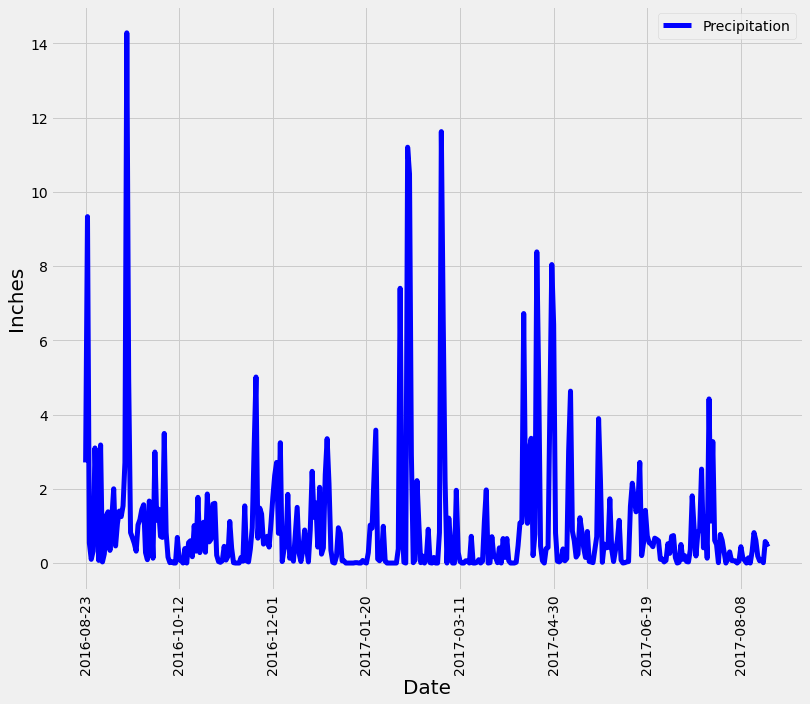

In [51]:
# Use Pandas Plotting with Matplotlib to plot the data
ax=climate_df.plot(color='b',figsize=(12,10), legend=True, linewidth=5.0, grid=True, rot=90)
ax.set_xlabel("Date", fontsize=20)
ax.set_ylabel("Inches", fontsize=20)

In [49]:
# Use Pandas to calcualte the summary statistics for the precipitation data
climate_df.describe()

,Precipitation
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


# Exploratory Station Analysis

In [31]:
# Design a query to calculate the total number stations in the dataset
Station_count = session.query(Station).group_by(Station.station).count()
Station_count

9

In [32]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
print(f"Number of stations available in this dataset.")
session.query(Measurement.station).distinct().count()
active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
                               group_by(Measurement.station).\
                               order_by(func.count(Measurement.station).desc()).all()
active_stations

Number of stations available in this dataset.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station,func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)]
station_temp_summary = session.query(*sel).\
        filter(Measurement.station == 'USC00519281').\
        group_by(Measurement.station)
for parameter in station_temp_summary:
    print(parameter)

('USC00519281', 54.0, 85.0, 71.66378066378067)


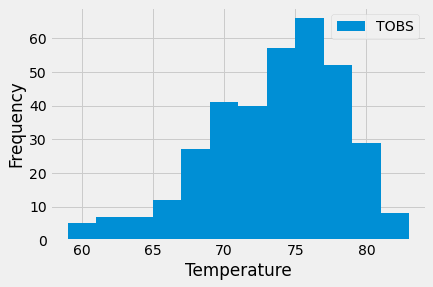

In [27]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.date, 
       Measurement.tobs]
station_TOBS = session.query(*sel).\
        filter(func.strftime(Measurement.date) >= start_date, Measurement.station == 'USC00519281').\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()
temps_df = pd.DataFrame(station_TOBS, columns=['Measurement_Date', 'Temperature'])

plt.hist(temps_df['Temperature'],bins=12, density=False, label="TOBS")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.figsize=(10,7)
plt.show()

# Close session

In [28]:
# Close Session
session.close()